## Validation of the user based recommender

In this notebook, we will validate the user based recommender we implemented. We will compare it with the Naive Recommender we first implemented.

In [8]:
import pandas as pd
import numpy as np
import utils as ut
import naive_recommender as nav
import similarity as sim
from user_based_recommender import user_based_recommender, generate_m

## Auxiliary functions

This functions are used to check de performance of the recommender. As the recommenders gives us sets of recommended movies, we will be using de Jaccard similarty. This similarity is defined as the intersection of the sets divided by the union of the sets.

In [9]:
def jaccard_similarity(set1, set2):
    """
    Calcula la similitud de Jaccard entre dos conjuntos.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0


def validate_recommenders_jaccard(user_id, validation_movies, rec1_movies, rec2_movies, matrix_genres):
    """
    Valida las recomendaciones comparando las distribuciones de géneros (basadas en conjuntos)
    entre las películas de validación y las recomendaciones utilizando similitud de Jaccard.
    """
    def calculate_genre_set(movies, matrix_genres):
        """
        Calcula el conjunto de géneros asociados a un conjunto de películas.
        
        Args:
            movies (list): Lista de IDs de películas.
            matrix_genres (DataFrame): Matriz de géneros (película vs. géneros).
            
        Returns:
            set: Conjunto de géneros asociados a las películas.
        """
        valid_movies = [movie_id for movie_id in movies if movie_id in matrix_genres.index]
        
        genre_set = set()
        for movie_id in valid_movies:
            genres = matrix_genres.loc[movie_id]
            genre_set.update(genres[genres == 1].index)  
            
        return genre_set

    validation_genres = calculate_genre_set(validation_movies, matrix_genres)
    rec1_genres = calculate_genre_set(rec1_movies, matrix_genres)
    rec2_genres = calculate_genre_set(rec2_movies, matrix_genres)

    rec1_similarity = jaccard_similarity(validation_genres, rec1_genres)
    rec2_similarity = jaccard_similarity(validation_genres, rec2_genres)

    return {
        "user_id": user_id,
        "rec1_similarity": rec1_similarity,
        "rec2_similarity": rec2_similarity,
        "validation_genres": validation_genres,
        "rec1_genres": rec1_genres,
        "rec2_genres": rec2_genres,
    }


### Testing

In [10]:
path_to_ml_latest_small = 'datasets/'
dataset = ut.load_dataset_from_source(path_to_ml_latest_small)

val_movies = 100  # Increased to reduce data sparsity
ratings_train, ratings_val = ut.split_users(dataset["ratings.csv"], val_movies)

matrix_genres = ut.matrix_genres(dataset["movies.csv"])
matrix_genres.reset_index(inplace=True)

m = generate_m(ratings_train, dataset["movies.csv"])

user_results = []
for user_id in ratings_val["userId"].unique()[:10]:
    validation_movies = ratings_val[ratings_val["userId"] == user_id]["movieId"].tolist()

    rec1 = nav.naive_recommender(ratings_train, dataset["movies.csv"])      
    rec1_movies = [movie_id for movie_id in rec1 if movie_id in matrix_genres.index][:10]

    if user_id in m.index:
        rec2 = user_based_recommender(user_id, m)
        if not rec2:
            print(f"No recommendations generated for user {user_id}")
            rec2_movies = []
        else:
            rec2_movies = [r[0] for r in rec2 if r[0] in matrix_genres.index][:10]

        result = validate_recommenders_jaccard(user_id, validation_movies, rec1_movies, rec2_movies, matrix_genres)
        user_results.append(result)
    else:
        print(f"User {user_id} not found in the training matrix. Skipping...")

c:\Users\Nico\Desktop\UPC\CAIM\Lab6 - Recommender Systems\utils.py:82: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for genre in genres: matrix.loc[idx_movie][genre] = 1


Average Jaccard Similarity:
  Naive Recommender: 0.1772
  User-based Recommender: 0.4704


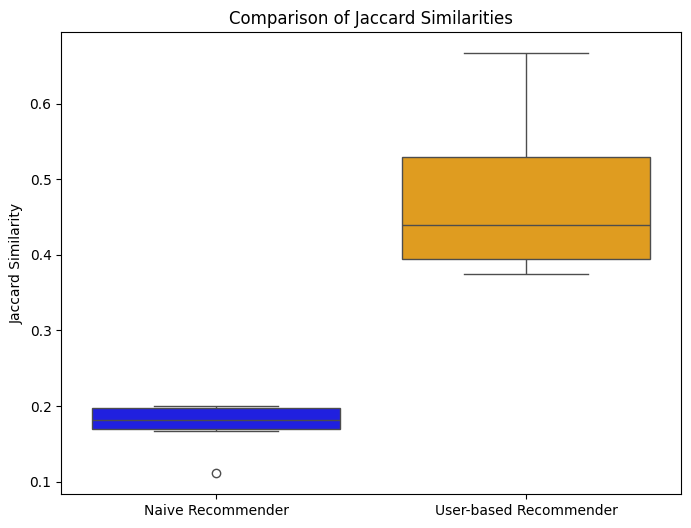

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract similarity scores for each recommender
rec1_similarities = [result['rec1_similarity'] for result in user_results]
rec2_similarities = [result['rec2_similarity'] for result in user_results]

print("Average Jaccard Similarity:")
print(f"  Naive Recommender: {np.mean(rec1_similarities):.4f}")
print(f"  User-based Recommender: {np.mean(rec2_similarities):.4f}")

plt.figure(figsize=(8, 6))
sns.boxplot(data=[rec1_similarities, rec2_similarities], palette=['blue', 'orange'])
plt.xticks([0, 1], ['Naive Recommender', 'User-based Recommender'])
plt.title('Comparison of Jaccard Similarities')
plt.ylabel('Jaccard Similarity')
plt.show()

In [12]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(rec1_similarities, rec2_similarities)

print("T-test Results:")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.4f}")

alpha = 0.05  # Significance level
if p_value < alpha:
    print("The difference in performance between the two recommenders is statistically significant.")
else:
    print("There is no statistically significant difference in performance between the two recommenders.")

T-test Results:
  T-statistic: -9.4322
  P-value: 0.0000
The difference in performance between the two recommenders is statistically significant.


In [13]:
import time

path_to_ml_latest_small = 'datasets/'
dataset = ut.load_dataset_from_source(path_to_ml_latest_small)

avg_naive_time = 0
avg_user_time = 0

val_movies = 5  # Increased to reduce data sparsity
ratings_train, ratings_val = ut.split_users(dataset["ratings.csv"], val_movies)

matrix_genres = ut.matrix_genres(dataset["movies.csv"])
matrix_genres.reset_index(inplace=True)

m = generate_m(ratings_train, dataset["movies.csv"])

user_results = []
for user_id in ratings_val["userId"].unique()[:10]:
    validation_movies = ratings_val[ratings_val["userId"] == user_id]["movieId"].tolist()

    start_time = time.time()
    rec1 = nav.naive_recommender(ratings_train, dataset["movies.csv"])      
    naive_time = time.time() - start_time
    avg_naive_time += naive_time
    rec1_movies = [movie_id for movie_id in rec1 if movie_id in matrix_genres.index][:10]

    if user_id in m.index:
        start_time = time.time()
        rec2 = user_based_recommender(user_id, m)
        user_time = time.time() - start_time
        avg_user_time += user_time

        if not rec2:
            print(f"No recommendations generated for user {user_id}")
            rec2_movies = []
        else:
            rec2_movies = [r[0] for r in rec2 if r[0] in matrix_genres.index][:10]

        result = validate_recommenders_jaccard(user_id, validation_movies, rec1_movies, rec2_movies, matrix_genres)
        user_results.append(result)
    else:
        print(f"User {user_id} not found in the training matrix. Skipping...")

avg_naive_time /= len(ratings_val["userId"].unique()[:10])
avg_user_time /= len(ratings_val["userId"].unique()[:10])

print(f"Average time for Naive Recommender: {avg_naive_time:.4f} seconds")
print(f"Average time for User-based Recommender: {avg_user_time:.4f} seconds")


c:\Users\Nico\Desktop\UPC\CAIM\Lab6 - Recommender Systems\utils.py:82: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for genre in genres: matrix.loc[idx_movie][genre] = 1


Average time for Naive Recommender: 0.0040 seconds
Average time for User-based Recommender: 8.2639 seconds


Average Jaccard Similarity:
  Naive Recommender: 0.3335
  User-based Recommender: 0.3221


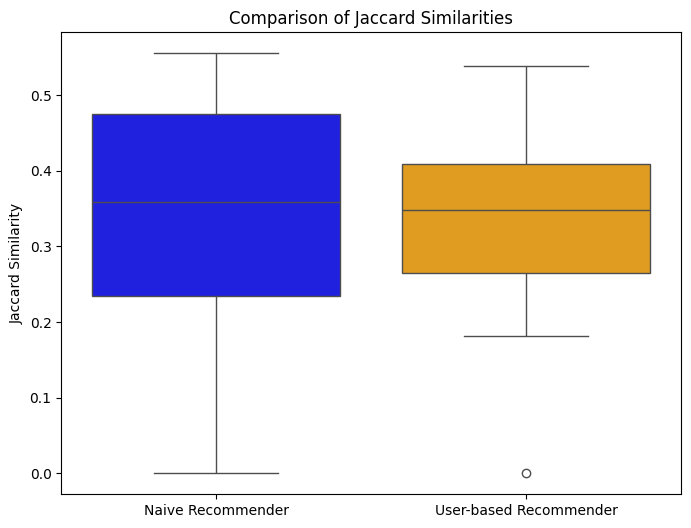

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract similarity scores for each recommender
rec1_similarities = [result['rec1_similarity'] for result in user_results]
rec2_similarities = [result['rec2_similarity'] for result in user_results]

print("Average Jaccard Similarity:")
print(f"  Naive Recommender: {np.mean(rec1_similarities):.4f}")
print(f"  User-based Recommender: {np.mean(rec2_similarities):.4f}")

plt.figure(figsize=(8, 6))
sns.boxplot(data=[rec1_similarities, rec2_similarities], palette=['blue', 'orange'])
plt.xticks([0, 1], ['Naive Recommender', 'User-based Recommender'])
plt.title('Comparison of Jaccard Similarities')
plt.ylabel('Jaccard Similarity')
plt.show()